<a href="https://colab.research.google.com/github/janchorowski/dl_uwr/blob/summer2021/Assignments/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5

**Submission deadlines:**
- get at least 4 points by Tuesday, 8.06 
- remaining points: last lab session of the semester

**Points:** Aim to get 12 out of 16 possible points.


## Submission instructions
The class is held remotely. To submit your solutions please show the notebook over the video call. Make sure you know all the questions and answers, and that the notebook contains results (before presentation do `Runtime -> Restart and run all`)

We provide a starter code, however, you are not required to use it as long as you properly solve the tasks.

As always, please submit corrections using GitHub's Pull Requests to https://github.com/janchorowski/dl_uwr.

# Problem 1: Generating 2 Moons data
Consider the 2D moons dataset generated in the starter code below. 

Train the following models: VAE, GAN, RealNVP. 

For each model visualize how the latent space is transformed into data points. Train a model with 2D latent space. Then whenever applicable:
1. Plot the data points along with a grid, then plot latent encodings of the data and the grid.
2. Generate latent encodings and a grid in latent space. Then sample data points based on the generated latent space and grid. Plot them in the data space.

Hint: for better visual mapping between original and latent representations of the data, use color on the scatterplots.

## Tasks:
1. [4p] Variational Autoencoder (VAE)

  Please use the following probability distributions:
    
  $$
    \begin{split}
    p(z) &= \mathcal{N}(z; \mu=0, \sigma^2=1)  \\
    p(x | z) &= \mathcal{N}(x; \mu=x_{\mu}(z), \sigma^2=x_{\sigma^2})
    \end{split}
  $$

  where: $x_{\mu}(z)$ is computed by a small neural network and $x_{\sigma^2}$ is a learned parameter.

  **Answer these questions:**
  
  1. Write down the formula for the reconstruction loss. The variance appears in two terms, what is their function?

  2. The reconstruction loss may fall below zero. How is this possible? 

  Compare the operation of the VAE for 2 Moons with a few widths. How is the loss dependent on the width? Why?

2. [3p] Generative Adversarial Network (GAN)

  Please use either a standard normal distribution for the latent space or a uniform distribution.

  **Answer these questions:**
  - Is the GAN generating all possible samples? Is it concentrating more on some regions of the data space?

3. [3p] Normalizing Flow (Real NVP model).

  The goal of Normalizing Flows is to learn invertible transformation between complex data distribution and some simple one, i.e. multivariate isotropic Gaussian. Since the latter is continuous, and our dataset is finite (hence in fact forms a discrete distribution, because you can memorize all observed values), we need to perform *dequantization*, that is add random noise to data at every iteration to train the model on an infinite stream of data. This is especially important in Problem 2 when RealNVP is applied to the MNIST data.

    **Answer these questions:**
  - Scale the input data by 0.01. Why is the negative log-likelihood negative?
  - For a few 2 moon widths compare the negative log-likelihood of the data with the values obtained with the VAE and present results in a table. How do they compare? Please note, that GAN's do not return likelihood computation.


# Problem 2: Generating MNIST

Next, choose one of the generative models (VAE, RealNVP, or GAN) and do the following using the MNIST dataset:

##Tasks
1. [2p] Train the model. Visualize generated samples (and test/train data reconstructions if you chose VAE).

Please properly define $p(x|z)$: when using a VAE, you can binarize the data and predict binary variables. For RealNVP, you can normalize the data to the 0-1 range, and add uniform noise $[0,1/255]$ to dequantize intensity values. GAN does not assume an output probability distribution and you may use raw data.

2. [1p] Linearly interpolate between two points in the latent space. Generate images from them and intermediate points. 

3. [1p] Try a different interpolation method, i.e. instead of going in a straight line from one point to another, follow the spherical curve of prior Gaussian distribution.

4. [2p] It is sometimes desirable to make use of available labels to gain control over classes of generated samples. Create a conditional generative model of your choice by injecting one-hot embeddings into the proper component(s). An example is [Conditional GAN](https://arxiv.org/abs/1411.1784), and its idea is applicable to other methods.


# Starter code

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Uniform
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose

device = "cpu"

/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Data

In [2]:
def generate_moons(width=1.0):
    moon1 = [
        [r * np.cos(a) - 2.5, r * np.sin(a) - 1.0]
        for r in np.arange(5 - width, 5 + width, 0.1 * width)
        for a in np.arange(0, np.pi, 0.01)
    ]
    moon2 = [
        [r * np.cos(a) + 2.5, r * np.sin(a) + 1.0]
        for r in np.arange(5 - width, 5 + width, 0.1 * width)
        for a in np.arange(np.pi, 2 * np.pi, 0.01)
    ]
    points = torch.tensor(moon1 + moon2)
    points += torch.rand(points.shape) * width
    return points.float()

In [3]:
class InMemDataLoader(object):
    __initialized = False
    def __init__(self, tensors, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        tensors = [torch.tensor(tensor) for tensor in tensors]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')
            
        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True
    
    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)
    
    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

/var/folders/nz/sz0gtb0n4990pkkc9bgjt7580000gn/T/ipykernel_7163/2583073299.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = [torch.tensor(tensor) for tensor in tensors]


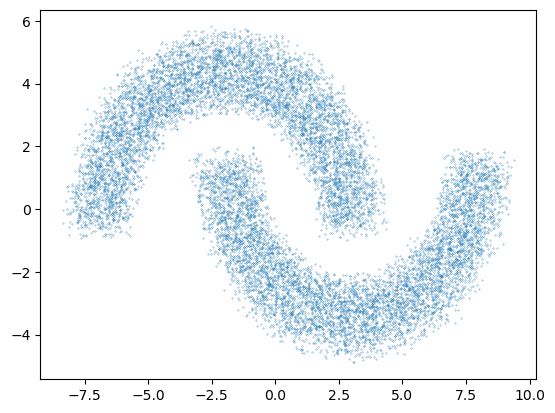

In [4]:
moons = generate_moons(width=1.0)
moons_dl = InMemDataLoader([moons], batch_size=2048, shuffle=True)
moons_dl.to(device)
plt.scatter(moons[:, 0], moons[:, 1], s=0.05)

## VAE

In [13]:
class VAE(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, z_dim=2):
        super(VAE, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, 2 * z_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, in_dim),
        )

        self.x_log_var = torch.nn.Parameter(torch.zeros(in_dim))

    def forward(self, x):
        sampled_z, z_mu, z_log_var = self.encode(x)
        x_mu, x_log_var = self.decode(sampled_z)
        return x_mu, x_log_var, z_mu, z_log_var

    def encode(self, x):
        z_mu_log_var = self.encoder(x)
        z_mu, z_log_var = torch.chunk(z_mu_log_var, 2, dim=1)
        z_std = torch.exp(0.5 * z_log_var)

        # Draw a sample from a standard Normal distribution with the same shape as z_std
        epsilon = torch.randn_like(z_std)

        # Reparametrization trick: shift and scale the random sample by z_mu and z_std
        z_samples = z_mu + epsilon * z_std

        return z_samples, z_mu, z_log_var


    def decode(self, sampled_z):
        x_mu = self.decoder(sampled_z)
        return x_mu, self.x_log_var

In [17]:
def gaussian_negative_log_likelihood(x, mu, log_var):
    var = torch.exp(log_var)
    return 0.5 * (torch.log(2 * np.pi * var) + torch.pow(x - mu, 2) / var)

def kullback_leibler_divergence_between_two_gaussians(mu1, log_var1, mu2, log_var2):
    return (
        log_var2 - log_var1 + (log_var1.exp() + (mu1 - mu2) ** 2) / (log_var2.exp()) - 1
    ) / 2

def reconstruction_loss(predicted_x_mu, predicted_x_log_var, real_x):
    """Return the negtive log-likelihood reconstruction loss:
        1/N \sum_i=1^N -\log N(x_i ; predicted_x_mu, I * exp(predicted_x_log_var)^2)
    """
    N = real_x.size(0)
    loss = gaussian_negative_log_likelihood(real_x, predicted_x_mu, predicted_x_log_var)
    loss = torch.mean(loss)
    return loss

def kl_loss(z_mu, z_log_var):
    """Compute Kullback–Leibler divergence between N(z_mu, exp(z_log_var)^2) and N(0,1)."""
    loss = kullback_leibler_divergence_between_two_gaussians(
        z_mu, z_log_var, torch.zeros_like(z_mu), torch.zeros_like(z_log_var)
    )
    loss = torch.mean(loss)
    return loss


In [18]:
hid_dim = 64
z_dim = 3
lr = 0.0003

vae = VAE(hid_dim=hid_dim, z_dim=z_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

  0%|          | 0/5001 [00:00<?, ?it/s]

Epoch: 0 loss: 1.3104 recon_loss: -0.8414 kl_loss: 2.1517 avg mean: -0.0371 avg std: 0.3614


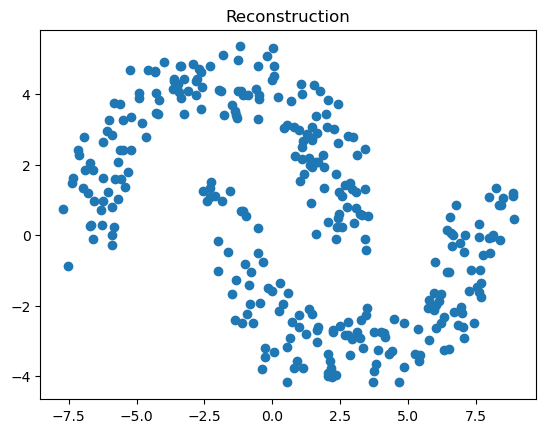

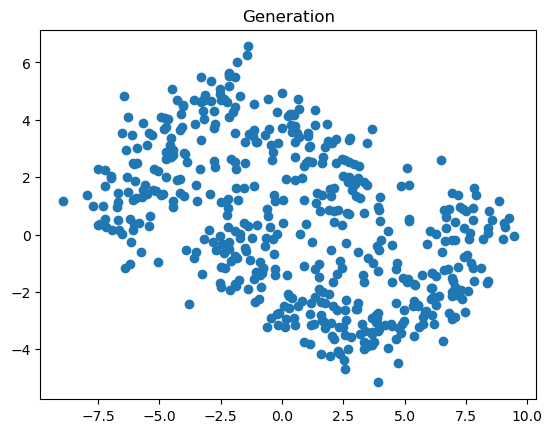

Epoch: 500 loss: 1.1470 recon_loss: -1.3480 kl_loss: 2.4949 avg mean: -0.0084 avg std: 0.3497


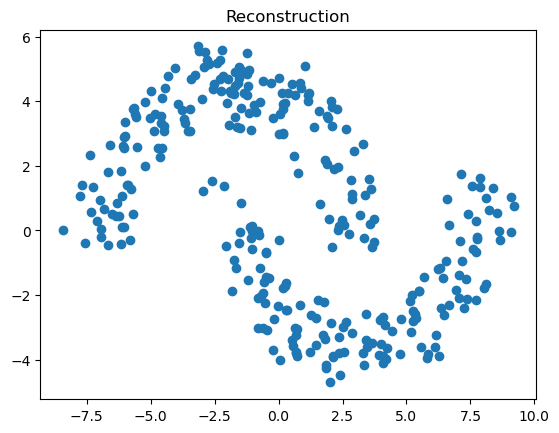

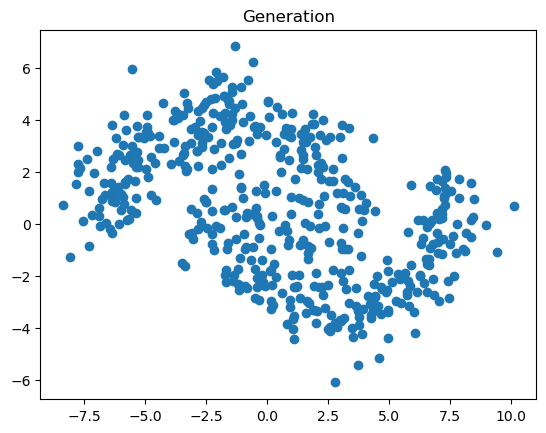

Epoch: 1000 loss: 1.0143 recon_loss: -1.8006 kl_loss: 2.8150 avg mean: 0.0118 avg std: 0.3404


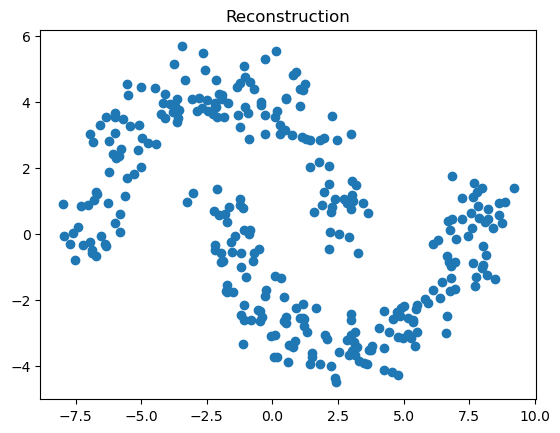

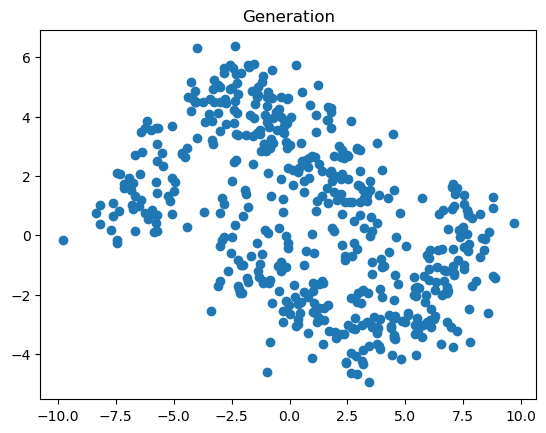

Epoch: 1500 loss: 0.8910 recon_loss: -2.2156 kl_loss: 3.1066 avg mean: 0.0061 avg std: 0.3370


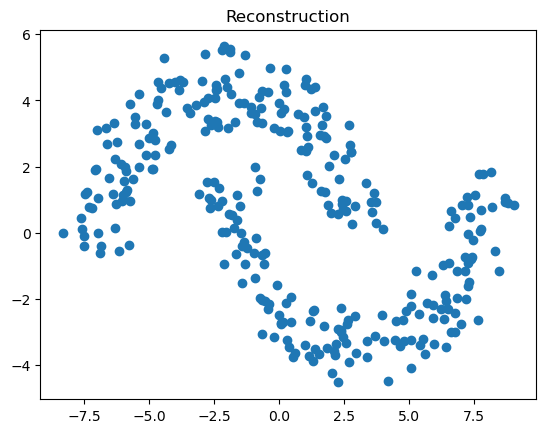

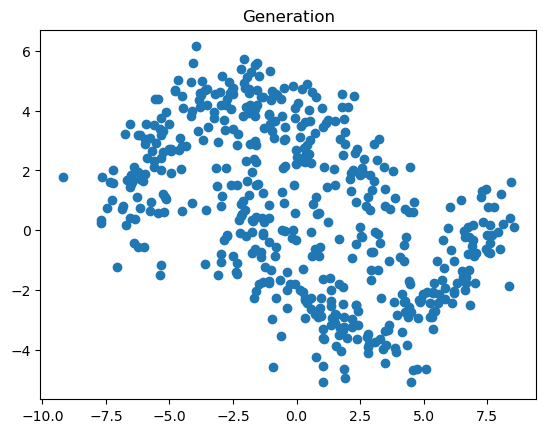

Epoch: 2000 loss: 0.8425 recon_loss: -2.4813 kl_loss: 3.3239 avg mean: 0.0118 avg std: 0.3294


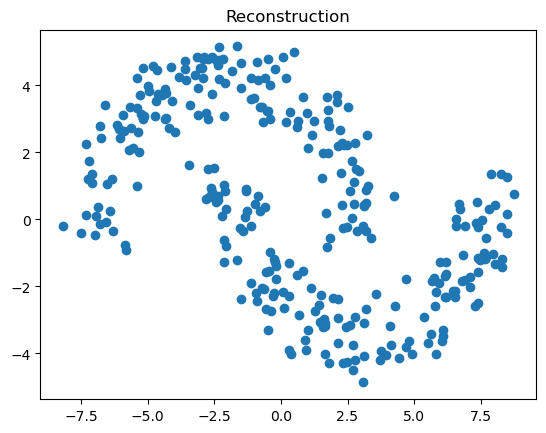

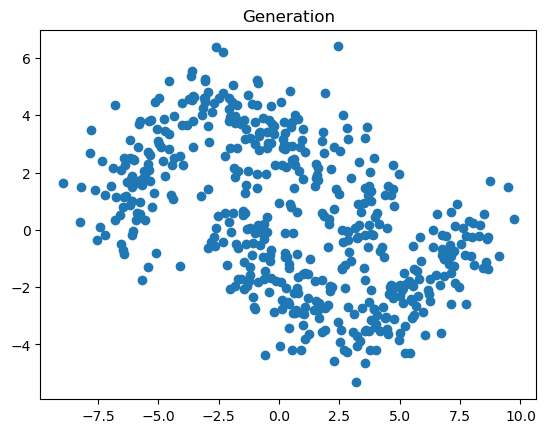

Epoch: 2500 loss: 0.8069 recon_loss: -2.6184 kl_loss: 3.4253 avg mean: -0.0107 avg std: 0.3308


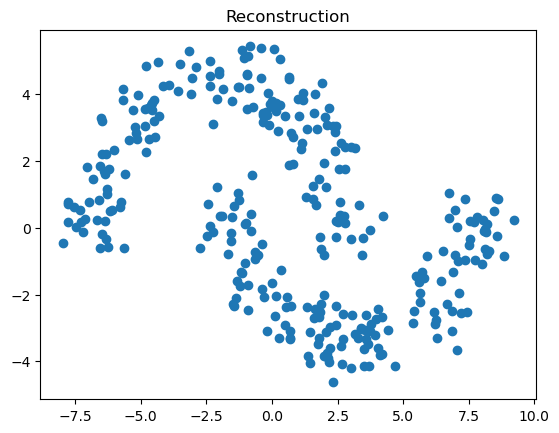

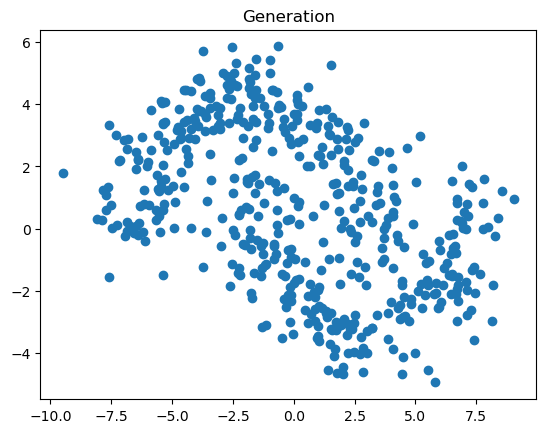

Epoch: 3000 loss: 0.8158 recon_loss: -2.6586 kl_loss: 3.4744 avg mean: -0.0097 avg std: 0.3311


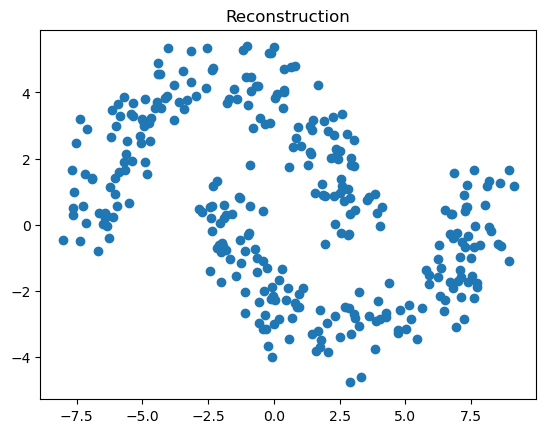

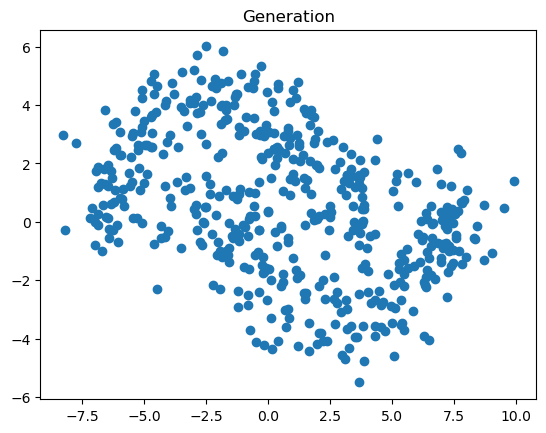

Epoch: 3500 loss: 0.7960 recon_loss: -2.7177 kl_loss: 3.5137 avg mean: -0.0188 avg std: 0.3314


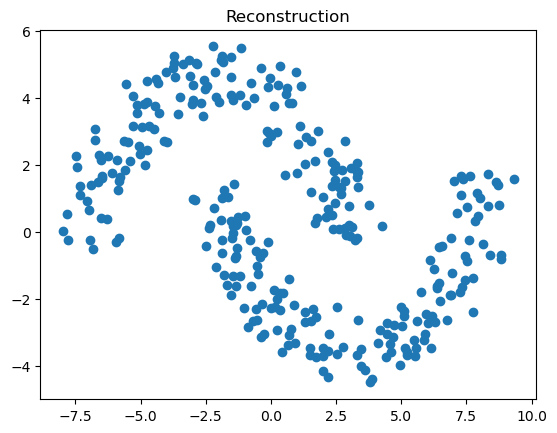

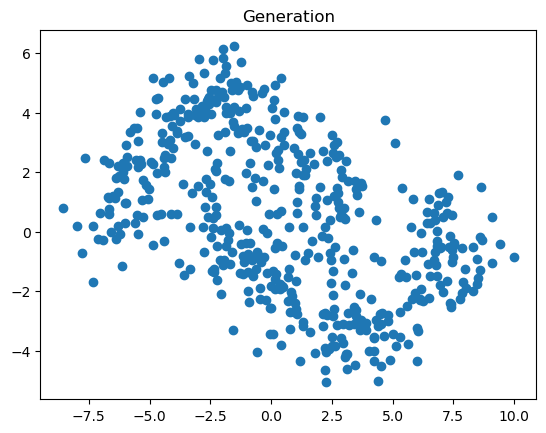

Epoch: 4000 loss: 0.8477 recon_loss: -2.7035 kl_loss: 3.5513 avg mean: -0.0409 avg std: 0.3292


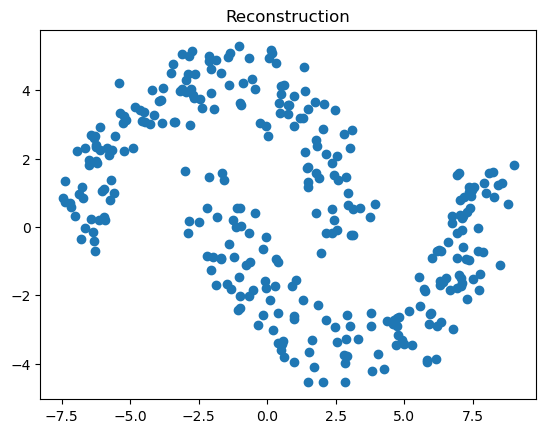

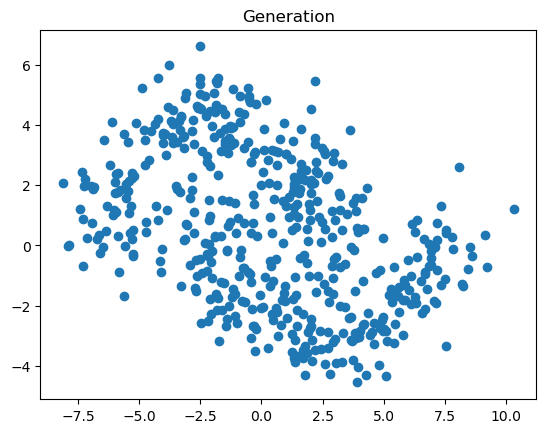

Epoch: 4500 loss: 0.7744 recon_loss: -2.7935 kl_loss: 3.5678 avg mean: -0.0574 avg std: 0.3318


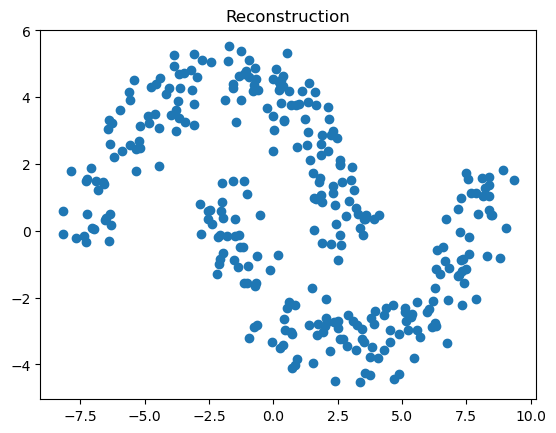

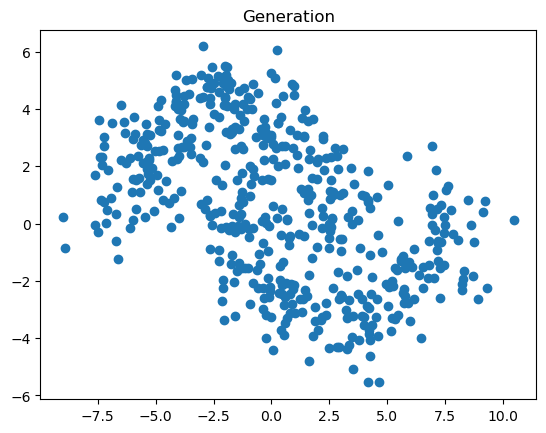

Epoch: 5000 loss: 0.7851 recon_loss: -2.8160 kl_loss: 3.6011 avg mean: -0.0578 avg std: 0.3332


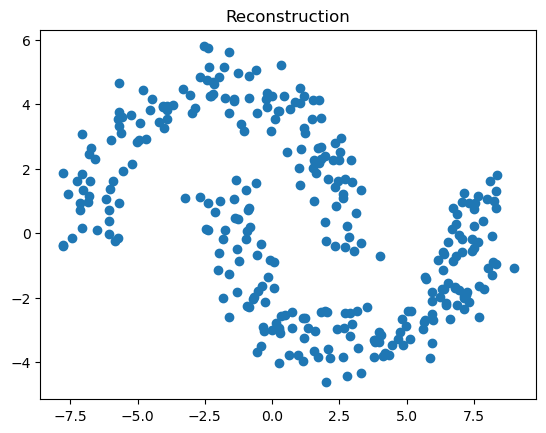

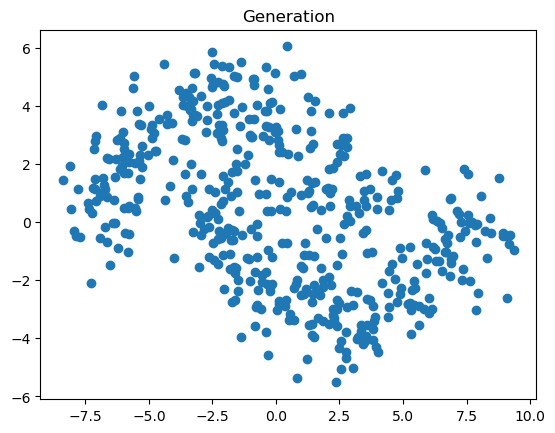

In [31]:
from tqdm.auto import tqdm
# Please note: the model should converge faster!
for i in tqdm(range(5001)):
    recon_loss_acc = 0.0
    kl_acc = 0.0
    vae.train()
    for x, in moons_dl:
        x = x.float().to(device)

        x_mu, x_log_var, z_mu, z_log_var = vae(x)

        optimizer.zero_grad()
        recon_loss = reconstruction_loss(x_mu, x_log_var, x)
        kl = kl_loss(z_mu, z_log_var)
        loss = recon_loss + kl
        loss.backward()
        optimizer.step()

        recon_loss_acc += recon_loss.item() * len(x)
        kl_acc += kl.item() * len(x)

    if i % 500 == 0:
        print(
            f"Epoch: {i} loss: {(recon_loss_acc + kl_acc) / len(moons) :.4f} recon_loss: {recon_loss_acc / len(moons) :.4f} kl_loss: {kl_acc / len(moons) :.4f} avg mean: {z_mu.detach().mean() :.4f} avg std: {torch.exp(z_log_var.detach() / 2).mean() :.4f}"
        )
        vae.eval()
        with torch.no_grad():
            # Reconstruct data
            x_recon = torch.randn(x.shape).to(device) * torch.exp(x_log_var / 2) + x_mu
            x_recon = x_recon.cpu()

            plt.scatter(x_recon[:, 0], x_recon[:, 1])
            plt.title("Reconstruction")
            plt.show()

            # Generate new data
            z = torch.randn(500, z_dim).to(device)
            x_gen_mu, x_gen_log_var = vae.decode(z)
            x_gen = (
                torch.randn(z.shape[0], 2).to(device) * torch.exp(x_gen_log_var / 2)
                + x_gen_mu
            )
            x_gen = x_gen.cpu()

            plt.scatter(x_gen[:, 0], x_gen[:, 1])
            plt.title("Generation")
            plt.show()

In [33]:
def get_grid(data):
    """Generate a dataset of points that lie on grid and span the given data range."""

    xmin, xmax = np.floor(data.min(0)), np.ceil(data.max(0))
    xg, yg = np.meshgrid(
        np.arange(xmin[0], xmax[0] + 1, 1), np.arange(xmin[1], xmax[1] + 1, 1)
    )
    mxg = np.hstack(
        (
            np.hstack((xg, np.zeros((xg.shape[0], 1)) + np.nan)).ravel(),
            np.hstack((xg.T, np.zeros((xg.shape[1], 1)) + np.nan)).ravel(),
        )
    )
    myg = np.hstack(
        (
            np.hstack((yg, np.zeros((yg.shape[0], 1)) + np.nan)).ravel(),
            np.hstack((yg.T, np.zeros((yg.shape[1], 1)) + np.nan)).ravel(),
        )
    )
    grid = np.vstack((mxg, myg)).T
    return grid

Text(0.5, 1.0, 'Data in latent space')

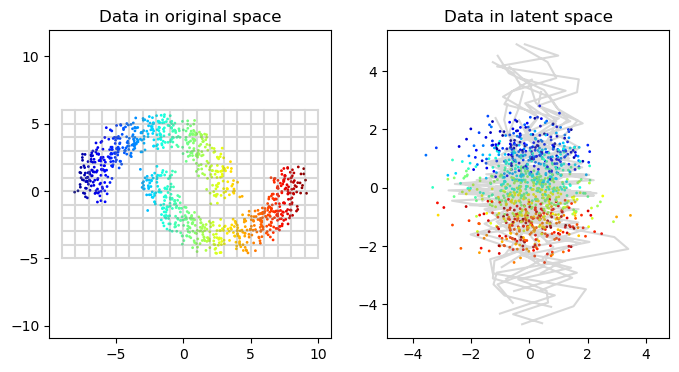

In [34]:
data = np.array(moons)[np.random.permutation(moons.shape[0])[:1000]]
grid = get_grid(data)

data_colors = (data[:, 0] - min(data[:, 0])) / (max(data[:, 0]) - min(data[:, 0]))
data_colors = plt.cm.jet(data_colors)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.plot(grid[:, 0], grid[:, 1], color="gray", alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in original space")

vae.eval()

plt.subplot(1, 2, 2)

# Convert numpy arrays to PyTorch tensors.
data_tensor = torch.from_numpy(data).float()
grid_tensor = torch.from_numpy(grid).float()

# Compute the latent encoding of the data and the grid
# Assuming the first output of vae.encode() is the mean of the latent variables
enc_data, _, _ = vae.encode(data_tensor)
enc_grid, _, _ = vae.encode(grid_tensor)

# Convert PyTorch tensors back to numpy arrays for plotting
enc_data = enc_data.detach().numpy()
enc_grid = enc_grid.detach().numpy()

plt.plot(enc_grid[:, 0], enc_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(enc_data[:, 0], enc_data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in latent space")

In [30]:
latent_samples = torch.randn(1000, z_dim)

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

vae.eval()

# Compute the projection into data space of the latent samples and the grid
# The decoder often outputs the mean and log variance, in that case we only take the mean
x_gen, _ = vae.decode(latent_samples)
grid_gen, _ = vae.decode(torch.from_numpy(latent_grid))

# Convert PyTorch tensors back to numpy arrays for plotting
x_gen = x_gen.detach().numpy()
grid_gen = grid_gen.detach().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)
plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")


RuntimeError: mat1 and mat2 must have the same dtype

## GAN

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, out_dim=2):
        super(Generator, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.layers = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
        )

    def forward(self, x):
        return self.layers(x)


class Discriminator(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, out_dim=1):
        super(Discriminator, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.layers = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
def generator_loss(DG, eps=1e-6):
    # Define Generator loss. Use eps for numerical stability of log.
    return TODO


def discriminator_loss(DR, DG, eps=1e-6):
    # Define Discriminator loss. Use eps for numerical stability of log.
    return


In [ ]:
z_dim = 2
hid_dim = 64
lr = 0.0001

G = Generator(in_dim=z_dim, hid_dim=hid_dim).to(device)
D = Discriminator(hid_dim=hid_dim).to(device)
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [ ]:
for i in range(7500):
    G_loss_acc = 0.0
    D_loss_acc = 0.0
    G.train()
    D.train()
    for x, in moons_dl:
        x = x.float().to(device)

        # Generate fake data from z ~ N(0,1).
        # Calculate Generator loss.
        z = torch.randn(x.size(0), z_dim, device=device)
        x_fake = TODO  # Use the generator to compute x_Fake

        # make a copy of x_fake and detach it, we'll use the copy to train the Discriminator
        x_fake_detached = x_fake.detach()

        G_loss = TODO  # Now use the discriminator and compute generator loss

        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # Calculate Discriminator loss.
        # Remember to use x_fake_detached to prevent backpropagating through generator!
        D_loss=

        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        G_loss_acc += G_loss.item() * len(x)
        D_loss_acc += D_loss.item() * len(x)

    if i % 100 == 0:
        G.eval()
        with torch.no_grad():
            z = torch.randn(1000, z_dim, device=device)
            x_gen = G(z).cpu()
            plt.scatter(x_gen[:, 0], x_gen[:, 1])
            plt.title(
                f"Epoch: {i} Generator loss: {G_loss_acc / len(moons) :.4f} Discriminator loss: {D_loss_acc / len(moons) :.4f}"
            )
            plt.show()

In [ ]:
latent_samples = torch.randn(1000, z_dim)

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

G.eval()
# TODO: compute the projection into data space of the latent saples and the grid
x_gen = TODO
grid_gen = TODO

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")

## Normalizing Flow

In [ ]:
class CouplingLayer(nn.Module):
    def __init__(self, idx, in_dim, hid_dim, out_dim):
        super(CouplingLayer, self).__init__()
        self.in_dim = in_dim // 2
        self.hid_dim = hid_dim
        self.out_dim = out_dim // 2
        self.odd = idx % 2 == 1

        self.s = nn.Sequential(
            nn.Linear(self.in_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.out_dim),
            nn.Tanh(),
        )

        self.t = nn.Sequential(
            nn.Linear(self.in_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.out_dim),
        )

    def forward(self, x, ldetJ):
        # Split x into two halves along dimension axis.
        x1, x2 = x[:, 0, None], x[:, 1, None]  # x1, x2 = TODO
        if self.odd:
            x1, x2 = x2, x1

        s = self.s(x1)
        t = self.t(x1)
        # Transform x2 using s and t.
        # x1 = x1
        x2 = TODO

        if self.odd:
            x1, x2 = x2, x1

        # Add log determinant of the Jacobian
        ldetJ += TODO

        return torch.cat([x1, x2], dim=1), ldetJ

    def invert(self, z):
        z1, z2 = z[:, 0, None], z[:, 1, None]
        if self.odd:
            z1, z2 = z2, z1

        s = self.s(z1)
        t = self.t(z1)
        # Invert the transformation of x2 from the forward step.
        # z1 = z1
        z2 = TODO

        if self.odd:
            z1, z2 = z2, z1

        return torch.cat([z1, z2], dim=1)


class RealNVP(nn.Module):
    def __init__(self, n_coupling_layers=4, in_dim=2, hid_dim=128, out_dim=2):
        super(RealNVP, self).__init__()
        assert n_coupling_layers % 2 == 0
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.coupling_layers = nn.ModuleList(
            [
                CouplingLayer(i, in_dim, hid_dim, out_dim)
                for i in range(n_coupling_layers)
            ]
        )

    def forward(self, x):
        ldetJ = 0.0
        for layer in self.coupling_layers:
            x, ldetJ = layer(x, ldetJ)
        return x, ldetJ

    def invert(self, z):
        for layer in reversed(self.coupling_layers):
            z = layer.invert(z)
        return z

In [ ]:
def nll_loss(z, ldetJ, prior_z):
    # Define negative log-likelihood loss for change of variable formula.
    # Hint: use prior_z.log_prob().
    return TODO


In [ ]:
n_coupling_layers = 6
hid_dim = 64
lr = 0.003

flow = RealNVP(n_coupling_layers=n_coupling_layers, hid_dim=hid_dim).to(device)
optimizer = optim.Adam(flow.parameters(), lr=lr)
prior_z = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

In [ ]:
for i in range(1000):
    loss_acc = 0.0
    flow.train()
    for x, in moons_dl:
        x = x.float().to(device)
        # dequantization - add a little random noise
        x += torch.rand(x.shape, device=device) / 1e2
        z, ldetJ = flow(x)

        loss = nll_loss(z, ldetJ, prior_z)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_acc += loss.item() * len(x)

    if i % 100 == 0:
        flow.eval()
        with torch.no_grad():
            z = prior_z.sample((1000,))
            x = flow.invert(z).cpu()
            plt.scatter(x[:, 0], x[:, 1])
            plt.title(f"Epoch: {i} nll loss: {loss_acc / len(moons) :.4f}")
            plt.show()

In [ ]:
data = np.array(moons)[np.random.permutation(moons.shape[0])[:1000]]
grid = get_grid(data)

data_colors = (data[:, 0] - min(data[:, 0])) / (max(data[:, 0]) - min(data[:, 0]))
data_colors = plt.cm.jet(data_colors)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.plot(grid[:, 0], grid[:, 1], color="gray", alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in original space")


plt.subplot(1, 2, 2)

# TODO: compute the latent encoding of the data nd the grid
enc_grid = TODO
enc_data = TODO

plt.plot(enc_grid[:, 0], enc_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(enc_data[:, 0], enc_data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in latent space")
plt.xlim(-5, 5)
plt.ylim(-5, 5)

In [ ]:
latent_samples = prior_z.sample((1000,)).cpu()

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

# TODO: compute the projection into data space of the latent saples and the grid
x_gen = TODO
grid_gen = TODO

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")

## MNIST